5.1 模型融合目标
- 对于多种 调参完成的模型 进行 模型融合
- 完成对于多种模型的融合，提交结果

5.2 内容介绍<br>
模型融合是比赛后期的一个重要环节，大体来说有如下的类型方式

1、简单加权融合
- 回归（分类概率）：算数平均融合（Arithmetic mean）,几何平均融合（Geometric mean）
- 分类：投票
- 综合：排序融合（rank averaging）,log融合

2、stacking/blending:
- 构建多层模型，并利用预测结果再拟合预测

3、boosting/bagging(在xgboost,Adaboost,GBDT中已经遇到)：
- 多树提升方法

5.3 stacking 相关理论介绍

（1）什么是stacking

Step1:

用训练集学习出 若干基学习器

Step2:

用学习器的预测结果做为新的训练集，来学习一个新的学习器

![jupyter](./pic/stacking.png)
**结合策略**
将个体学习器结合在一起的时候使用的方法叫做结合策略。
- 对于分类问题：使用投票法选择输出最多的类
- 对于回归问题：将多分类器结果求平均值
- 用另外一个 机器学习算法 将 个体机器学习器 的结果结合在一起，这就是Stacking

在stacking方法中，将个体学习器叫做**初级学习器**，用于结合的学习器叫做**次级学习器**或**元学习器**（meta-learner）,次级学习器用于训练的数据叫做**次级训练集**

次级训练集是在训练集上用初级学习器得到的

（2） 如何进行stacking

算法示意图如下：

![jupyter](./pic/stacking_alg.png)

- 过程1—3是训练出T个个体学习器，也就是初级学习器
- 过程5—9是使用训练出来的个体学习器来得预测的结果，这个预测结果当做次级学习器的训练集
- 过程11是用初级学习器预测的结果训练出次级学习器，得到我们最后训练的模型

（3）stacking方法讲解：

详细见https://tianchi.aliyun.com/notebook-ai/detail?spm=5176.12281978.0.0.68021b438BRm0A&postId=95535

   Stacking本质上就是这么直接的思路，但是直接这样有时对于如果训练集和测试集分布不那么一致的情况下是有一点问题的，其问题在于用初始模型训练的标签再利用真实标签进行再训练，毫无疑问会导致一定的模型过拟合训练集，这样或许模型在测试集上的泛化能力或者说效果会有一定的下降，因此现在的问题变成了如何降低再训练的过拟合性，这里我们一般有两种方法。

- 次级模型尽量选择简单的线性模型
- 利用K折交叉验证



### 5.4代码示例

#### 5.4.1 回归/分类概率融合
（1）简单加权平均，结果直接融合

In [2]:
## 生成一些简单的样本数据，test_prei 代表第i个模型的预测值
test_pre1 = [1.2, 3.2, 2.1, 6.2]
test_pre2 = [0.9, 3.1, 2.0, 5.9]
test_pre3 = [1.1, 2.9, 2.2, 6.0]

# y_test_true 代表模型的真实值
y_test_true = [1, 3, 2, 6]


In [3]:
import numpy as np
import pandas as pd

#定义结果的加权平均函数
def Weighted_mothod(test_pre1, test_pre2, test_pre3, w = [1/3, 1/3, 1/3]):
    Weighted_result = w[0] * pd.Series(test_pre1) + w[1] * pd.Series(test_pre2) + w[2] * pd.Series(test_pre3)
    return Weighted_result


In [6]:
from sklearn.metrics import mean_absolute_error as MAE
# 各模型的结果计算MAE
print('Pred1 MAE:',MAE(y_test_true, test_pre1))
print('Pred2 MAE:',MAE(y_test_true, test_pre2))
print('Pred3 MAE:',MAE(y_test_true, test_pre3))

Pred1 MAE: 0.1750000000000001
Pred2 MAE: 0.07499999999999993
Pred3 MAE: 0.10000000000000009


In [7]:
## 根据加权计算MAE
w = [0.3, 0.4, 0.3]# 定义比重权值
Weighted_pre = Weighted_mothod(test_pre1, test_pre2, test_pre3, w)
print('Weight_pre MAE', MAE(y_test_true, Weighted_pre))

Weight_pre MAE 0.05750000000000027


可以发现结果有所提升，这就是简单的加权平均

还有一些特殊的形式，比如mean平均，median平均

In [13]:
def Mean_method(test_pre1, test_pre2, test_pre3):
    Mean_result = pd.concat([pd.Series(test_pre1),pd.Series(test_pre2),pd.Series(test_pre3)],axis=1).mean(axis = 1)
    return Mean_result
# axis = 0按照列，axis = 1按照行

In [14]:
Mean_pre = Mean_method(test_pre1,test_pre2,test_pre3)
print('Mean_pre MAE:',MAE(y_test_true, Mean_pre))

Mean_pre MAE: 0.06666666666666693


In [16]:
#原来的
def Median_method(test_pre1,test_pre2,test_pre3):
    Median_result = pd.concat([pd.Series(test_pre1),pd.Series(test_pre2),pd.Series(test_pre3)],axis=1)
    return Median_result

Median_method(test_pre1,test_pre2,test_pre3)

,0,1,2
0,1.2,0.9,1.1
1,3.2,3.1,2.9
2,2.1,2.0,2.2
3,6.2,5.9,6.0


In [17]:
## 定义结果的加权平均函数
def Median_method(test_pre1,test_pre2,test_pre3):
    Median_result = pd.concat([pd.Series(test_pre1),pd.Series(test_pre2),pd.Series(test_pre3)],axis=1).median(axis=1)
    return Median_result

Median_method(test_pre1,test_pre2,test_pre3)

0    1.1
1    3.1
2    2.1
3    6.0
dtype: float64

In [18]:
Median_pre = Median_method(test_pre1,test_pre2,test_pre3)
print('Median_pre MAE:',MAE(y_test_true, Median_pre))

Median_pre MAE: 0.07500000000000007


（2）Stacking 融合（回归）：

In [19]:
from sklearn import linear_model

def Stacking_method(train_reg1, train_reg2, train_reg3, y_train_true, test_pre1, test_pre2, test_pre3, model_L2 = linear_model.LinearRegression()):
    model_L2.fit(pd.concat([pd.Series(train_reg1),pd.Series(train_reg2),pd.Series(train_reg3)],axis=1).values,y_train_true)
    Stacking_result = model_L2.predict(pd.concat([pd.Series(test_pre1),pd.Series(test_pre2),pd.Series(test_pre3)],axis=1).values)
    return Stacking_result

In [20]:
## 生成一些简单的样本数据，test_prei 代表第i个模型的预测值
train_reg1 = [3.2, 8.2, 9.1, 5.2]
train_reg2 = [2.9, 8.1, 9.0, 4.9]
train_reg3 = [3.1, 7.9, 9.2, 5.0]
# y_test_true 代表第模型的真实值
y_train_true = [3, 8, 9, 5] 

test_pre1 = [1.2, 3.2, 2.1, 6.2]
test_pre2 = [0.9, 3.1, 2.0, 5.9]
test_pre3 = [1.1, 2.9, 2.2, 6.0]

# y_test_true 代表第模型的真实值
y_test_true = [1, 3, 2, 6] 

In [21]:
model_L2= linear_model.LinearRegression()
Stacking_pre = Stacking_method(train_reg1,train_reg2,train_reg3,y_train_true,
                               test_pre1,test_pre2,test_pre3,model_L2)
print('Stacking_pre MAE:',MAE(y_test_true, Stacking_pre))

Stacking_pre MAE: 0.042134831460675204


可以发现模型结果相对于之前有进一步的提升，这是我们需要注意的一点是，对于第二层Stacking的模型不宜选取的过于复杂，这样会导致模型在训练集上过拟合，从而使得在测试集上并不能达到很好的效果。

5.4.2 分类模型融合

对于分类，同样可以使用融合方法，如简单投票，Stacking

In [22]:
from sklearn.datasets import make_blobs
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

(1)Voting投票机制：

Voting即投票机制，分为软投票和硬投票两种，其原理采用少数服从多数的思想。


In [29]:
'''
硬投票：对多各模型直接进行投票，不区分模型对结果的相对重要度，最终投票数目最多的类
为最终被预测的类
'''
iris = datasets.load_iris()
x = iris.data
y = iris.target
print(x.shape)
print(y.shape)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)


clf1 = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=3, min_child_weight=2, subsample=0.7,
                     colsample_bytree=0.6, objective='binary:logistic')
clf2 = RandomForestClassifier(n_estimators=50, max_depth=1, min_samples_split=4,
                              min_samples_leaf=63,oob_score=True)
clf3 = SVC(C=0.1)

# 硬投票
eclf = VotingClassifier(estimators=[('xgb', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')
for clf, label in zip([clf1, clf2, clf3, eclf], ['XGBBoosting', 'Random Forest', 'SVM', 'Ensemble']):
    scores = cross_val_score(clf, x, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

(150, 4)
(150,)
Accuracy: 0.96 (+/- 0.02) [XGBBoosting]
Accuracy: 0.33 (+/- 0.00) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [SVM]
Accuracy: 0.91 (+/- 0.02) [Ensemble]


In [28]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [30]:
'''
软投票：和硬投票原理相同，增加了设置权重的功能，可以为不同模型设置不同权重，进而区别模型不同的重要度。
'''
x=iris.data
y=iris.target
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

clf1 = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=3, min_child_weight=2, subsample=0.8,
                     colsample_bytree=0.8, objective='binary:logistic')
clf2 = RandomForestClassifier(n_estimators=50, max_depth=1, min_samples_split=4,
                              min_samples_leaf=63,oob_score=True)
clf3 = SVC(C=0.1, probability=True)

# 软投票
eclf = VotingClassifier(estimators=[('xgb', clf1), ('rf', clf2), ('svc', clf3)], voting='soft', weights=[2, 1, 1])
clf1.fit(x_train, y_train)

for clf, label in zip([clf1, clf2, clf3, eclf], ['XGBBoosting', 'Random Forest', 'SVM', 'Ensemble']):
    scores = cross_val_score(clf, x, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.96 (+/- 0.02) [XGBBoosting]
Accuracy: 0.33 (+/- 0.00) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [SVM]
Accuracy: 0.96 (+/- 0.02) [Ensemble]


(2)分类的stacking/Blending 融合

stacking是一种分层模型集成框架。

以两层为例，第一层由多个基学习器组成，其输入为原始训练集，第二层的模型则是以第一层基学习器的输出作为训练集进行再训练，从而得到完整的stacking模型, stacking两层模型都使用了全部的训练数据。

In [32]:
'''
5-Fold Stacking
'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import pandas as pd
#创建训练的数据集
data_0 = iris.data
data = data_0[:100,:]

target_0 = iris.target
target = target_0[:100]

#模型融合中使用到的各个单模型
clfs = [LogisticRegression(solver='lbfgs'),
        RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
        GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=5)]
 
#切分一部分数据作为测试集
X, X_predict, y, y_predict = train_test_split(data, target, test_size=0.3, random_state=2020)

dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
dataset_blend_test = np.zeros((X_predict.shape[0], len(clfs)))

#5折stacking
n_splits = 5
skf = StratifiedKFold(n_splits)
skf = skf.split(X, y)

for j, clf in enumerate(clfs):
    #依次训练各个单模型
    dataset_blend_test_j = np.zeros((X_predict.shape[0], 5))
    for i, (train, test) in enumerate(skf):
        #5-Fold交叉训练，使用第i个部分作为预测，剩余的部分来训练模型，获得其预测的输出作为第i部分的新特征。
        X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]
        clf.fit(X_train, y_train)
        y_submission = clf.predict_proba(X_test)[:, 1]
        dataset_blend_train[test, j] = y_submission
        dataset_blend_test_j[:, i] = clf.predict_proba(X_predict)[:, 1]
    #对于测试集，直接用这k个模型的预测值均值作为新的特征。
    dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)
    print("val auc Score: %f" % roc_auc_score(y_predict, dataset_blend_test[:, j]))

clf = LogisticRegression(solver='lbfgs')
clf.fit(dataset_blend_train, y)
y_submission = clf.predict_proba(dataset_blend_test)[:, 1]

print("Val auc Score of Stacking: %f" % (roc_auc_score(y_predict, y_submission)))

val auc Score: 1.000000
val auc Score: 0.500000
val auc Score: 0.500000
val auc Score: 0.500000
val auc Score: 0.500000
Val auc Score of Stacking: 1.000000


Blending，其实和Stacking是一种类似的多层模型融合的形式

其主要思路是把原始的训练集先分成两部分，比如70%的数据作为新的训练集，剩下30%的数据作为测试集。

在第一层，我们在这70%的数据上训练多个模型，然后去预测那30%数据的label，同时也预测test集的label。

在第二层，我们就直接用这30%数据在第一层预测的结果做为新特征继续训练，然后用test集第一层预测的label做特征，用第二层训练的模型做进一步预测

其优点在于：

1.比stacking简单（因为不用进行k次的交叉验证来获得stacker feature）

2.避开了一个信息泄露问题：generlizers和stacker使用了不一样的数据集
缺点在于：

1.使用了很少的数据（第二阶段的blender只使用training set10%的量）

2.blender可能会过拟合

3.stacking使用多次的交叉验证会比较稳健 '''


In [33]:
'''
Blending
'''
 
#创建训练的数据集
#创建训练的数据集
data_0 = iris.data
data = data_0[:100,:]

target_0 = iris.target
target = target_0[:100]
 
#模型融合中使用到的各个单模型
clfs = [LogisticRegression(solver='lbfgs'),
        RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        #ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
        GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=5)]
 
#切分一部分数据作为测试集
X, X_predict, y, y_predict = train_test_split(data, target, test_size=0.3, random_state=2020)

#切分训练数据集为d1,d2两部分
X_d1, X_d2, y_d1, y_d2 = train_test_split(X, y, test_size=0.5, random_state=2020)
dataset_d1 = np.zeros((X_d2.shape[0], len(clfs)))
dataset_d2 = np.zeros((X_predict.shape[0], len(clfs)))
 
for j, clf in enumerate(clfs):
    #依次训练各个单模型
    clf.fit(X_d1, y_d1)
    y_submission = clf.predict_proba(X_d2)[:, 1]
    dataset_d1[:, j] = y_submission
    #对于测试集，直接用这k个模型的预测值作为新的特征。
    dataset_d2[:, j] = clf.predict_proba(X_predict)[:, 1]
    print("val auc Score: %f" % roc_auc_score(y_predict, dataset_d2[:, j]))

#融合使用的模型
clf = GradientBoostingClassifier(learning_rate=0.02, subsample=0.5, max_depth=6, n_estimators=30)
clf.fit(dataset_d1, y_d2)
y_submission = clf.predict_proba(dataset_d2)[:, 1]
print("Val auc Score of Blending: %f" % (roc_auc_score(y_predict, y_submission)))

val auc Score: 1.000000
val auc Score: 1.000000
val auc Score: 1.000000
val auc Score: 1.000000
val auc Score: 1.000000
Val auc Score of Blending: 1.000000


(3)分类Stacking的融合

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.95 (+/- 0.02) [Stacking Classifier]


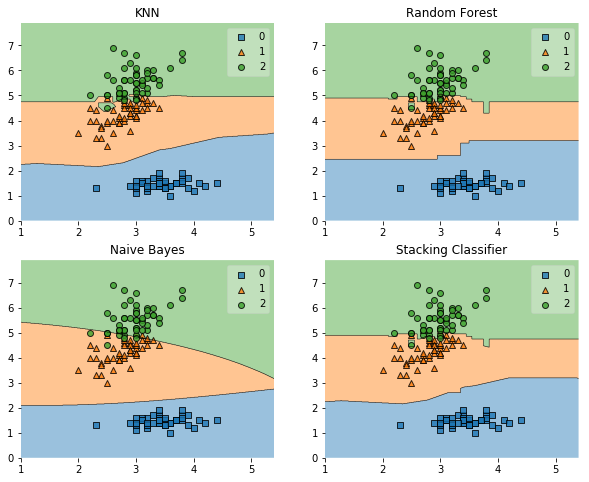

In [35]:


import warnings
warnings.filterwarnings('ignore')
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

# 以python自带的鸢尾花数据集为例
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)

plt.show()

可以发现 基模型 用 'KNN', 'Random Forest', 'Naive Bayes' 然后再这基础上 次级模型加一个 'LogisticRegression'，模型测试效果有着很好的提升。

5.4.3 一些其他方法

将特征放进模型中预测，并将预测结果变换并作为新的特征加入原有特征中再经过模型预测结果 （Stacking变化）¶
（可以反复预测多次将结果加入最后的特征中）

In [36]:
def Ensemble_add_feature(train,test,target,clfs):
    
    # n_flods = 5
    # skf = list(StratifiedKFold(y, n_folds=n_flods))

    train_ = np.zeros((train.shape[0],len(clfs*2)))
    test_ = np.zeros((test.shape[0],len(clfs*2)))

    for j,clf in enumerate(clfs):
        '''依次训练各个单模型'''
        # print(j, clf)
        '''使用第1个部分作为预测，第2部分来训练模型，获得其预测的输出作为第2部分的新特征。'''
        # X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]

        clf.fit(train,target)
        y_train = clf.predict(train)
        y_test = clf.predict(test)

        ## 新特征生成
        train_[:,j*2] = y_train**2
        test_[:,j*2] = y_test**2
        train_[:, j+1] = np.exp(y_train)
        test_[:, j+1] = np.exp(y_test)
        # print("val auc Score: %f" % r2_score(y_predict, dataset_d2[:, j]))
        print('Method ',j)
    
    train_ = pd.DataFrame(train_)
    test_ = pd.DataFrame(test_)
    return train_,test_


In [37]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

data_0 = iris.data
data = data_0[:100,:]

target_0 = iris.target
target = target_0[:100]

x_train,x_test,y_train,y_test=train_test_split(data,target,test_size=0.3)
x_train = pd.DataFrame(x_train) ; x_test = pd.DataFrame(x_test)

#模型融合中使用到的各个单模型
clfs = [LogisticRegression(),
        RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
        GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=5)]

New_train,New_test = Ensemble_add_feature(x_train,x_test,y_train,clfs)

clf = LogisticRegression()
# clf = GradientBoostingClassifier(learning_rate=0.02, subsample=0.5, max_depth=6, n_estimators=30)
clf.fit(New_train, y_train)
y_emb = clf.predict_proba(New_test)[:, 1]

print("Val auc Score of stacking: %f" % (roc_auc_score(y_test, y_emb)))

Method  0
Method  1
Method  2
Method  3
Method  4
Val auc Score of stacking: 1.000000


5.4.4 赛题示例

In [38]:
import seaborn as sns

warnings.filterwarnings('ignore')
%matplotlib inline

import itertools
import matplotlib.gridspec as gridspec
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
# from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
# from mlxtend.plotting import plot_learning_curves
# from mlxtend.plotting import plot_decision_regions

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

In [39]:
## 数据读取
Train_data = pd.read_csv('../data/used_car_train_20200313.csv', sep=' ')
TestA_data = pd.read_csv('../data/used_car_testA_20200313.csv', sep=' ')

print(Train_data.shape)
print(TestA_data.shape)

(150000, 31)
(50000, 30)


In [40]:
Train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [41]:
numerical_cols = Train_data.select_dtypes(exclude = 'object').columns
print(numerical_cols)

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'regionCode', 'seller', 'offerType',
       'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14'],
      dtype='object')


In [42]:
feature_cols = [col for col in numerical_cols if col not in ['SaleID','name','regDate','price']]

In [43]:
X_data = Train_data[feature_cols]
Y_data = Train_data['price']

X_test  = TestA_data[feature_cols]

print('X train shape:',X_data.shape)
print('X test shape:',X_test.shape)

X train shape: (150000, 26)
X test shape: (50000, 26)


In [44]:
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))

In [45]:
print('Sta of label:')
Sta_inf(Y_data)

Sta of label:
_min 11
_max: 99999
_mean 5923.327333333334
_ptp 99988
_std 7501.973469876635
_var 56279605.942732885


In [46]:
X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)

In [47]:
def build_model_lr(x_train,y_train):
    reg_model = linear_model.LinearRegression()
    reg_model.fit(x_train,y_train)
    return reg_model

def build_model_ridge(x_train,y_train):
    reg_model = linear_model.Ridge(alpha=0.8)#alphas=range(1,100,5)
    reg_model.fit(x_train,y_train)
    return reg_model

def build_model_lasso(x_train,y_train):
    reg_model = linear_model.LassoCV()
    reg_model.fit(x_train,y_train)
    return reg_model

def build_model_gbdt(x_train,y_train):
    estimator =GradientBoostingRegressor(loss='ls',subsample= 0.85,max_depth= 5,n_estimators = 100)
    param_grid = { 
            'learning_rate': [0.05,0.08,0.1,0.2],
            }
    gbdt = GridSearchCV(estimator, param_grid,cv=3)
    gbdt.fit(x_train,y_train)
    print(gbdt.best_params_)
    # print(gbdt.best_estimator_ )
    return gbdt

def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=120, learning_rate=0.08, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=5) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=63,n_estimators = 100)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm


(2)XGBoost的五折交叉回归验证实现

In [49]:
## xgb
from sklearn.metrics import mean_absolute_error
xgr = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) # ,objective ='reg:squarederror'

scores_train = []
scores = []

## 5折交叉验证方式
sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for train_ind,val_ind in sk.split(X_data,Y_data):
    
    train_x=X_data.iloc[train_ind].values
    train_y=Y_data.iloc[train_ind]
    val_x=X_data.iloc[val_ind].values
    val_y=Y_data.iloc[val_ind]
    
    xgr.fit(train_x,train_y)
    pred_train_xgb=xgr.predict(train_x)
    pred_xgb=xgr.predict(val_x)
    
    score_train = mean_absolute_error(train_y,pred_train_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y,pred_xgb)
    scores.append(score)

print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))

Train mae: 594.8909340395033
Val mae 693.382067947197


(3)划分数据集， 并用多种方法训练和预测

In [50]:
## Split data with val
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)

## Train and Predict
print('Predict LR...')
model_lr = build_model_lr(x_train,y_train)
val_lr = model_lr.predict(x_val)
subA_lr = model_lr.predict(X_test)

print('Predict Ridge...')
model_ridge = build_model_ridge(x_train,y_train)
val_ridge = model_ridge.predict(x_val)
subA_ridge = model_ridge.predict(X_test)

print('Predict Lasso...')
model_lasso = build_model_lasso(x_train,y_train)
val_lasso = model_lasso.predict(x_val)
subA_lasso = model_lasso.predict(X_test)

print('Predict GBDT...')
model_gbdt = build_model_gbdt(x_train,y_train)
val_gbdt = model_gbdt.predict(x_val)
subA_gbdt = model_gbdt.predict(X_test)


Predict LR...
Predict Ridge...
Predict Lasso...
Predict GBDT...
{'learning_rate': 0.2}


一般比赛中效果最为显著的两种方法

In [51]:
print('predict XGB...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
subA_xgb = model_xgb.predict(X_test)

print('predict lgb...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
subA_lgb = model_lgb.predict(X_test)

predict XGB...
predict lgb...


In [52]:
print('Sta inf of lgb:')
Sta_inf(subA_lgb)

Sta inf of lgb:
_min -280.7380240419688
_max: 88782.1143044527
_mean 5926.331254325851
_ptp 89062.85232849467
_std 7362.190662618817
_var 54201851.3527517


（1）加权融合

In [53]:
def Weighted_method(test_pre1,test_pre2,test_pre3,w=[1/3,1/3,1/3]):
    Weighted_result = w[0]*pd.Series(test_pre1)+w[1]*pd.Series(test_pre2)+w[2]*pd.Series(test_pre3)
    return Weighted_result

## Init the Weight
w = [0.3,0.4,0.3]

## 测试验证集准确度
val_pre = Weighted_method(val_lgb,val_xgb,val_gbdt,w)
MAE_Weighted = mean_absolute_error(y_val,val_pre)
print('MAE of Weighted of val:',MAE_Weighted)

## 预测数据部分
subA = Weighted_method(subA_lgb,subA_xgb,subA_gbdt,w)
print('Sta inf:')
Sta_inf(subA)
## 生成提交文件
sub = pd.DataFrame()
sub['SaleID'] = X_test.index
sub['price'] = subA
sub.to_csv('./sub_Weighted.csv',index=False)

MAE of Weighted of val: 730.6081856718638
Sta inf:
_min -88.85069199362046
_max: 88247.67969943957
_mean 5928.533940288071
_ptp 88336.53039143319
_std 7341.737087314087
_var 53901103.45924313


In [54]:
## 与简单的LR（线性回归）进行对比
val_lr_pred = model_lr.predict(x_val)
MAE_lr = mean_absolute_error(y_val,val_lr_pred)
print('MAE of lr:',MAE_lr)

MAE of lr: 2593.018995220566


（2）Stacking融合

In [55]:
## Starking

## 第一层
train_lgb_pred = model_lgb.predict(x_train)
train_xgb_pred = model_xgb.predict(x_train)
train_gbdt_pred = model_gbdt.predict(x_train)

Strak_X_train = pd.DataFrame()
Strak_X_train['Method_1'] = train_lgb_pred
Strak_X_train['Method_2'] = train_xgb_pred
Strak_X_train['Method_3'] = train_gbdt_pred

Strak_X_val = pd.DataFrame()
Strak_X_val['Method_1'] = val_lgb
Strak_X_val['Method_2'] = val_xgb
Strak_X_val['Method_3'] = val_gbdt

Strak_X_test = pd.DataFrame()
Strak_X_test['Method_1'] = subA_lgb
Strak_X_test['Method_2'] = subA_xgb
Strak_X_test['Method_3'] = subA_gbdt

In [56]:
Strak_X_test.head()

,Method_1,Method_2,Method_3
0,40323.360674,38442.433594,37317.179439
1,275.184319,327.227081,206.197173
2,6876.171916,7504.832520,7052.177040
3,11671.895851,11517.415039,11955.059527
4,572.032387,561.744629,533.142129


In [57]:
## level2-method 
model_lr_Stacking = build_model_lr(Strak_X_train,y_train)
## 训练集
train_pre_Stacking = model_lr_Stacking.predict(Strak_X_train)
print('MAE of Stacking-LR:',mean_absolute_error(y_train,train_pre_Stacking))

## 验证集
val_pre_Stacking = model_lr_Stacking.predict(Strak_X_val)
print('MAE of Stacking-LR:',mean_absolute_error(y_val,val_pre_Stacking))

## 预测集
print('Predict Stacking-LR...')
subA_Stacking = model_lr_Stacking.predict(Strak_X_test)


MAE of Stacking-LR: 627.782076276947
MAE of Stacking-LR: 719.8894663833835
Predict Stacking-LR...


In [58]:
subA_Stacking[subA_Stacking<10]=10  ## 去除过小的预测值

sub = pd.DataFrame()
sub['SaleID'] = TestA_data.SaleID
sub['price'] = subA_Stacking
sub.to_csv('./sub_Stacking.csv',index=False)

In [59]:
print('Sta inf:')
Sta_inf(subA_Stacking)

Sta inf:
_min 10.0
_max: 89112.82582581835
_mean 5927.336826224908
_ptp 89102.82582581835
_std 7397.445879213381
_var 54722205.535891026


3.4 经验总结
比赛的融合这个问题，个人的看法来说其实涉及多个层面，也是提分和提升模型鲁棒性的一种重要方法：

1）结果层面的融合，这种是最常见的融合方法，其可行的融合方法也有很多，比如根据结果的得分进行加权融合，还可以做Log，exp处理等。在做结果融合的时候，有一个很重要的条件是模型结果的得分要比较近似，然后结果的差异要比较大，这样的结果融合往往有比较好的效果提升。

2）特征层面的融合，这个层面其实感觉不叫融合，准确说可以叫分割，很多时候如果我们用同种模型训练，可以把特征进行切分给不同的模型，然后在后面进行模型或者结果融合有时也能产生比较好的效果。

3）模型层面的融合，模型层面的融合可能就涉及模型的堆叠和设计，比如加Staking层，部分模型的结果作为特征输入等，这些就需要多实验和思考了，基于模型层面的融合最好不同模型类型要有一定的差异，用同种模型不同的参数的收益一般是比较小的。